# An Investigation of Danish Fertility

In the recent years, danish policymakers have expressed concern for the state of the national fertility rates. According to the danish newspaper Berlingske, a danish woman would in 2022 on average give birth to 1,55 children (see [this website](https://www.berlingske.dk/samfund/foedselsraten-falder-i-naesten-alle-landsdele-koebenhavn-er-blandt-de)). 
To sustain the population size without taking immigration into consideration, a woman would need to give birth to 2,1 children. However cynical it may sound, it is of great economical interest why the fertility rates are declining, because policy makers are already introducing measures to deal with the decline. In her new years speech, the prime mininister adressed to the nation that extra rounds of fertility treatment would become accessible for free for danish women in the forthcoming year. In this project, we investigate the determining factors for the danish fertility.


In [49]:
# Import of relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import mpl_axes_aligner

# Autoreload modules when code is run
# %load_ext autoreload
# %autoreload 2

# User written modules
import dataproject


In [48]:
# pip install mpl-axes-aligner
# pip install git+https://github.com/alemartinello/dstapi

In [35]:
from IPython.display import display
import requests
from dstapi import DstApi

# Development in GDP and fertility rate

We use data from Statistics Denmark, specifically the two datasets NAN1 and HISB3. We import the relevant variables from these datasets using an API.

From NAN1 we import data on yearly growth in GDP from 1966 to 2023. 

In [36]:
from dataproject import*
BNP = data_NAN1()

# How is data structured?
BNP.head()

,TRANSAKT,PRISENHED,TID,INDHOLD
0,B.1*g Gross domestic product,Period-to-period real growth (per cent),1979,3.9
1,B.1*g Gross domestic product,Period-to-period real growth (per cent),2022,2.7
2,B.1*g Gross domestic product,Period-to-period real growth (per cent),2005,2.3
3,B.1*g Gross domestic product,Period-to-period real growth (per cent),1985,4.0
4,B.1*g Gross domestic product,Period-to-period real growth (per cent),1991,1.4


In [37]:
# Drop the irrelevant descriptive columns "TRANSAKT" and "PRISENHED".
drop_these = ['TRANSAKT','PRISENHED']
BNP.drop(drop_these, axis=1, inplace=True)

# Rename columns to more suitable variable names.
BNP.rename(columns = {'INDHOLD':'growth', 'TID':'year'}, inplace=True)

# Drop missing entries.
I = BNP.loc[BNP.growth == '..'] 
BNP.drop(I.index, inplace=True)

# Sort dataset by year.
BNP.sort_values(by = ['year'], inplace=True)

# Convert all entries to float.
BNP['growth'] = BNP['growth'].astype('float')
BNP.head()


,year,growth
41,1967,5.5
51,1968,5.6
29,1969,6.5
12,1970,1.6
49,1971,3.0


From HISB3 we import data on number of women and number of livebirths from 1901 to 2023.

In [62]:
# Load the data.
HIS = data_HISB3()

# How is data structured?
HIS.head()

,BEVÆGELSE,TID,INDHOLD
0,"Women January 1. (in 1,000)",1996,2659
1,Total number of livebirths,1996,67638
2,"Women January 1. (in 1,000)",1989,2602
3,Total number of livebirths,1989,61351
4,"Women January 1. (in 1,000)",1992,2618


In [63]:
# Sort dataset on year and variable.
HIS.sort_values(by = ['TID','BEVÆGELSE'], inplace=True)

# Rename time variable. We rename the column with number of births and women after sorting. 
HIS.rename(columns = {'TID':'year'}, inplace=True)

# Create subsets of odd and even rows to separate births and amount of women.
even = HIS.iloc[::2].copy()
odd = HIS.iloc[1::2].copy()

# Rename the even column "INDHOLD" to number of births.
even.rename(columns={'INDHOLD':'births'}, inplace=True)
print(even)

# Rename the odd column "INDHOLD" to number of women.
odd.rename(columns = {'INDHOLD': 'women'}, inplace=True)

# Merge the subsets on year.
fertility = pd.merge(even, odd, how='inner', on=['year'])

# Drop the irrelevant descriptive columns.
drop = ['BEVÆGELSE_x', 'BEVÆGELSE_y']
fertility.drop(drop,axis=1,inplace=True)

# Drop missing entries.
fertility = fertility.dropna()
I = fertility.loc[fertility.births == '..'] 
fertility.drop(I.index, inplace=True)
I_2 = fertility.loc[fertility.women == '..'] 
fertility.drop(I_2.index, inplace=True)

# Convert entry type to float.
fertility['births'] = fertility['births'].astype('float')
fertility['women'] = fertility['women'].astype('float')

fertility.head()


                      BEVÆGELSE  year births
181  Total number of livebirths  1901  73219
87   Total number of livebirths  1902  72839
52   Total number of livebirths  1903  72351
104  Total number of livebirths  1904  73692
53   Total number of livebirths  1905  73082
..                          ...   ...    ...
169  Total number of livebirths  2020  60937
97   Total number of livebirths  2021  63473
79   Total number of livebirths  2022  58430
119  Total number of livebirths  2023  57469
81   Total number of livebirths  2024     ..

[124 rows x 3 columns]


,year,births,women
0,1901,73219.0,1255.0
1,1902,72839.0,1271.0
2,1903,72351.0,1286.0
3,1904,73692.0,1300.0
4,1905,73082.0,1316.0


In [64]:
# Calculate fertility as births per 1000 women in a new column
fertility['fertility'] = fertility['births']/fertility['women']

# Calculate yearly change in fertility in a new column
fertility['rate'] = fertility['fertility'].pct_change()

# Remove NaN
fertility = res.dropna() 
fertility.head()

,year,births,women,fertility,rate
1,1902,72839.0,1271.0,57.308419,-0.017713
2,1903,72351.0,1286.0,56.260498,-0.018286
3,1904,73692.0,1300.0,56.686154,0.007566
4,1905,73082.0,1316.0,55.533435,-0.020335
5,1906,74217.0,1331.0,55.760331,0.004086


We combine the constructed datasets of GDP and fertility.

In [65]:
# Merge on year
GDP_fertility = pd.merge(res,BNP, how = 'inner', on = ['year'])

# Set index to year instead of 0, 1 ...
GDP_fertility= GDP_fertility.set_index('year')
GDP_fertility.tail()


,births,women,fertility,rate,growth
year,,,,,
2019,61167.0,2917.0,20.969146,-0.009119,1.5
2020,60937.0,2926.0,20.826042,-0.006825,-2.4
2021,63473.0,2935.0,21.626235,0.038423,6.8
2022,58430.0,2951.0,19.800068,-0.084442,2.7
2023,57469.0,2984.0,19.259048,-0.027324,1.9


# Illustrate relationship between GDP and fertility rate

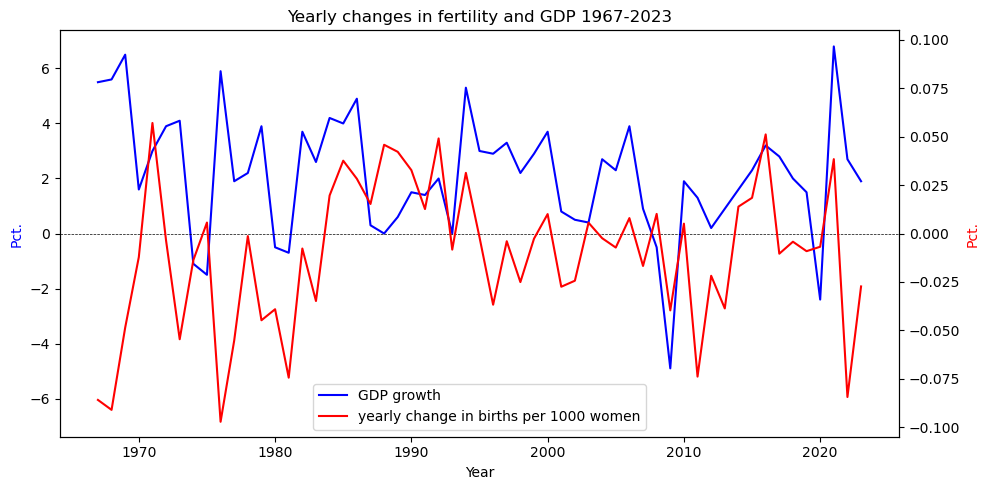

In [60]:
# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot GDP growth on the primary y-axis
ax1.plot(GDP_fertility.index, GDP_fertility['growth'], color='b', label='GDP growth')
ax1.set_xlabel('Year')
ax1.set_ylabel('Pct.', color='b')

# Create a secondary y-axis and plot fertility
ax2 = ax1.twinx()  
ax2.plot(GDP_fertility.index, inner['rate'], color='r', label='yearly change in births per 1000 women')
ax2.set_ylabel('Pct.', color='r')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc = 'lower center')

# Add title
plt.title('Yearly changes in fertility and GDP 1967-2023')

# Align y-axes
mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.5)

# Add line through 0
ax1.axhline(0, linewidth=0.5, color='black', linestyle='--')
fig.tight_layout()

# Show plot
plt.show()

Comment on the development of GDP growth and change in births per 1000 women:

The GDP typically rises during periods of economic prosperity and falls during economic downturns. It's reasonable to assume a positive correlation between GDP and the number of births, as economic growth often enhances economic security. This increased security can create greater confidence in the future, thereby encouraging individuals to start families.

We anticipate a delayed response in fertility due to the duration of a pregnancy. This can be seen from the above  graph, notably in the 1970s, 1980s, and following the financial crisis in 2008, where the decline in birth rates follows after the drop in GDP growth.

However, the pattern in the graph appears somewhat arbitrary, which is why we seek to uncover a potential relationship between education level and fertility.

If a relationship between GDP growth and fertility should exist, we would expect the fertility to react with a lag due to the duration of a pregnancy. The graph above shows a somewhat arbitrary pattern, why we seek to uncover a potential relationship between education level and fertility.

# Development in women's education level

We use data on women's educational attainment from the dataset HFUDD11 from Statistics Denmark. The data is only available from 2008 to 2022. 

In [52]:
# Load data on educational attainment using an API. 
hfudd1 = DstApi('HFUDD11')
display(hfudd1.tablesummary(language='en'))

hfudd11 = data_HFUDD11()
hfudd11.head()

# Drop irrelevant columns
drop_these = ['BOPOMR','HERKOMST', 'KØN']
hfudd11.drop(drop_these, axis=1, inplace=True)

# Rename colums
hfudd11.rename(columns={'TID':'Year' ,'INDHOLD':'Number of women','ALDER':'Age'}, inplace=True)  

hfudd11.head()


Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BOPOMR,105,000,All Denmark,851,Aalborg,False
1,HERKOMST,4,TOT,Total,3,Descendant,False
2,HFUDD,93,TOT,Total,H9099,H9099 Not stated,False
3,ALDER,12,TOT,"Age, total",65-69,65-69 years,False
4,KØN,3,TOT,Total,K,Women,False
5,Tid,16,2008,2008,2023,2023,True


,HFUDD,Age,Year,Number of women
0,H10 Primary education,20-24 years,2008,40780
1,H10 Primary education,25-29 years,2008,26981
2,H10 Primary education,30-34 years,2008,27719
3,H10 Primary education,35-39 years,2008,31359
4,H10 Primary education,40-44 years,2008,37998


In [53]:
# Summarize number of women in each age group for each year and level of education. 
hfudd11_sum = hfudd11.groupby(['HFUDD', 'Year'])['Number of women'].sum().reset_index()

hfudd11_sum.head()


,HFUDD,Year,Number of women
0,H10 Primary education,2008,164837
1,H10 Primary education,2009,160586
2,H10 Primary education,2010,157632
3,H10 Primary education,2011,153895
4,H10 Primary education,2012,149454


We illustrate the development in women's educational attainment with a interactive plot showing the developemnt for each level of education individually. 

In [45]:
hfudd11_sum = pd.DataFrame(hfudd11_sum)

# Construction of the plot
def plot_e(hfudd11_sum, HFUDD): 
    filtered_df = hfudd11_sum[hfudd11_sum['HFUDD'] == HFUDD]
    ax = filtered_df.plot(x='Year', y='Number of women', style='-o', legend=False)
    ax.set_title(f'Number of Women at {HFUDD} Education Level')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Women')
    plt.show()

# Dropdown menu for education level
education_levels = hfudd11_sum['HFUDD'].unique()
widgets.interact(plot_e, 
                 hfudd11_sum=widgets.fixed(hfudd11_sum),
                 HFUDD=widgets.Dropdown(description='HFUDD', 
                                        options=education_levels, 
                                        value=education_levels[0]));

interactive(children=(Dropdown(description='HFUDD', options=('H10 Primary education', 'H20 Upper secondary edu…

The plot shows....

# Concluding remark